In [1]:
import numpy as np
import os
import tensorflow as tf
import gc
import pandas as pd
import matplotlib.pyplot as plt

from image_utils import deprocess_image
from data_utils import load_tiny_imagenet

In [2]:
#%% load data
data = load_tiny_imagenet('datasets/tiny-imagenet-100-A', subtract_mean=True)


loading training data for synset 20 / 100
loading training data for synset 40 / 100
loading training data for synset 60 / 100
loading training data for synset 80 / 100
loading training data for synset 100 / 100


In [10]:
num_train = len(data['X_train'])/25
small_data = {
  'X_train': data['X_train'][0:num_train:2], #(200, 3, 64, 64)
  'y_train': data['y_train'][0:num_train:2], #(200)
  'X_val': data['X_val'],
  'y_val': data['y_val'],
  'class_names': data['class_names'],  #100
  'mean_image': data['mean_image']
}

print len(small_data['X_train'])
print small_data['class_names']


1000
[['Egyptian cat'], ['reel'], ['volleyball'], ['rocking chair', 'rocker'], ['lemon'], ['bullfrog', 'Rana catesbeiana'], ['basketball'], ['cliff', 'drop', 'drop-off'], ['espresso'], ['plunger', "plumber's helper"], ['parking meter'], ['German shepherd', 'German shepherd dog', 'German police dog', 'alsatian'], ['dining table', 'board'], ['monarch', 'monarch butterfly', 'milkweed butterfly', 'Danaus plexippus'], ['brown bear', 'bruin', 'Ursus arctos'], ['school bus'], ['pizza', 'pizza pie'], ['guinea pig', 'Cavia cobaya'], ['umbrella'], ['organ', 'pipe organ'], ['oboe', 'hautboy', 'hautbois'], ['maypole'], ['goldfish', 'Carassius auratus'], ['potpie'], ['hourglass'], ['seashore', 'coast', 'seacoast', 'sea-coast'], ['computer keyboard', 'keypad'], ['Arabian camel', 'dromedary', 'Camelus dromedarius'], ['ice cream', 'icecream'], ['nail'], ['space heater'], ['cardigan'], ['baboon'], ['snail'], ['coral reef'], ['albatross', 'mollymawk'], ['spider web', "spider's web"], ['sea cucumber', 'h

In [4]:
def next_batch(x, y, index_in_epoch, batch_size):
    num_examples = x.shape[0]
    start = index_in_epoch
    index_in_epoch += batch_size
    if index_in_epoch > num_examples:
        # Shuffle the data
        perm = np.arange(num_examples)
        np.random.shuffle(perm)
        x = x[perm]
        y = y[perm]
        # Start next epoch
        start = 0
        index_in_epoch = batch_size
        assert batch_size <= num_examples
    end = index_in_epoch
    return x[start:end], y[start:end],index_in_epoch

In [30]:
del data
gc.collect

<function gc.collect>

In [5]:
#%%
# 2.4 Build inference graph.
def conv2d(x, W):
  """conv2d returns a 2d convolution layer with full stride."""
  return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')


def max_pool_2x2(x):
  """max_pool_2x2 downsamples a feature map by 2X."""
  return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                        strides=[1, 2, 2, 1], padding='SAME')

def weight_variable(shape, name='weight'):
  """weight_variable generates a weight variable of a given shape."""
  initial = tf.truncated_normal(shape, stddev=0.1)
  return tf.Variable(initial, name=name)

def bias_variable(shape, name='bias'):
  """bias_variable generates a bias variable of a given shape."""
  initial = tf.constant(0.1, shape=shape)
  return tf.Variable(initial, name=name)

def variable_summaries(var):
  """Attach a lot of summaries to a Tensor (for TensorBoard visualization)."""
  with tf.name_scope('summaries'):
    mean = tf.reduce_mean(var)
    with tf.name_scope('stddev'):
      stddev = tf.sqrt(tf.reduce_mean(tf.square(var - mean)))

def mnist_inference(images, hidden1_units, hidden2_units):
    """Build the MNIST model up to where it may be used for inference.
    Args:
        images: Images placeholder.
        hidden1_units: Size of the first hidden layer.
        hidden2_units: Size of the second hidden layer.
    Returns:
        logits: Output tensor with the computed logits.
    """
    with tf.name_scope('input_reshape'):
        x_image = tf.reshape(images, [-1, 64, 64, 3])

    # Convolution 1
    with tf.name_scope('conv1'):
        # First convolutional layer - maps one grayscale image to 32 feature maps.
        W_conv1 = weight_variable([5, 5, 3, 32], 'W_conv1')
        b_conv1 = bias_variable([32], 'b_conv1')
        h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)
        # Pooling layer - downsamples by 2X.
        h_pool1 = max_pool_2x2(h_conv1)
        norm1 = tf.nn.lrn(h_pool1, 4, bias=1.0, alpha=0.001 / 9.0, beta=0.75,
                    name='norm1')

    # Convolution 2
    with tf.name_scope('conv2'):
        # Second convolutional layer -- maps 32 feature maps to 64.
        W_conv2 = weight_variable([5, 5, 32, 64], 'W_conv1')
        b_conv2 = bias_variable([64], 'b_conv1')
        h_conv2 = tf.nn.relu(conv2d(norm1, W_conv2) + b_conv2)
        # Second pooling layer.
        h_pool2 = max_pool_2x2(h_conv2)  
        norm2 = tf.nn.lrn(h_pool2, 4, bias=1.0, alpha=0.001 / 9.0, beta=0.75,
                    name='norm2')

    # Hidden 1
    with tf.name_scope('hidden1'):
        # Fully connected layer 1 -- after 2 round of downsampling, our 28x28 image
        # is down to 7x7x64 feature maps -- maps this to 1024 features.
        tmp = norm2.get_shape().as_list()[1]
        W_fc1 = weight_variable([tmp * tmp * 64, hidden1_units], 'W_fc1')
        b_fc1 = bias_variable([1024], 'b_fc1')
        norm2_flat = tf.reshape(norm2, [-1, tmp*tmp*64])
        h_fc1 = tf.nn.relu(tf.matmul(norm2_flat, W_fc1) + b_fc1)
        variable_summaries(W_fc1)
        variable_summaries(b_fc1)
        # Dropout - controls the complexity of the model, prevents co-adaptation of
        # features.
        keep_prob = tf.placeholder(tf.float32)
        tf.add_to_collection("prop", keep_prob)  # Remember this Op.
        h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

    # Hidden 2
    with tf.name_scope('hidden2'):
        # Map the 1024 features to 10 classes, one for each digit
        W_fc2 = weight_variable([hidden1_units, hidden2_units], 'W_fc2')
        b_fc2 = bias_variable([hidden2_units], 'b_fc2')
        variable_summaries(W_fc2)
        variable_summaries(b_fc2)
        y_conv = tf.matmul(h_fc1_drop, W_fc2) + b_fc2
    return y_conv, keep_prob

#%%
# 2.5 Build training graph.
def mnist_training(logits, labels, learning_rate):
    """Build the training graph.

    Args:
        logits: Logits tensor, float - [BATCH_SIZE, NUM_CLASSES].
        labels: Labels tensor, int32 - [BATCH_SIZE], with values in the
          range [0, NUM_CLASSES).
        learning_rate: The learning rate to use for gradient descent.
    Returns:
        train_op: The Op for training.
        loss: The Op for calculating loss.
    """
    # Create an operation that calculates loss.
    labels = tf.to_int64(labels)
    cross_entropy = tf.nn.sparse_softmax_cross_entropy_with_logits(
        logits=logits, labels=labels, name='xentropy')
    loss = tf.reduce_mean(cross_entropy, name='xentropy_mean')
    # Create the gradient descent optimizer with the given learning rate.
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=0.9, beta2=0.999, epsilon=1e-08)
    # Create a variable to track the global step.
    global_step = tf.Variable(0, name='global_step', trainable=False)
    # Use the optimizer to apply the gradients that minimize the loss
    # (and also increment the global step counter) as a single training step.
    train_op = optimizer.minimize(loss, global_step=global_step)

    # Uncomment the following line to see what we have constructed.
    # tf.train.write_graph(tf.get_default_graph().as_graph_def(),
    #                      "/tmp", "train.pbtxt", as_text=True)
    
    return train_op, loss

In [11]:
#%% Overfit small data


HIDDEN1_UNITS = 1024
HIDDEN2_UNITS = 100
MODEL_SAVE_PATH = 'model'
MAX_STEPS = 60

mnist_graph = tf.Graph()
with mnist_graph.as_default():
    # Generate placeholders for the images and labels.
    images_placeholder = tf.placeholder(tf.float32)
    labels_placeholder = tf.placeholder(tf.int32)
    tf.add_to_collection("images", images_placeholder)  # Remember this Op.
    tf.add_to_collection("labels", labels_placeholder)  # Remember this Op.


    # Build a Graph that computes predictions from the inference model.
    logits, keep_prob = mnist_inference(images_placeholder,
                             HIDDEN1_UNITS,
                             HIDDEN2_UNITS)
    tf.add_to_collection("logits", logits)  # Remember this Op.

    # Add to the Graph the Ops that calculate and apply gradients.
    train_op, loss_op = mnist_training(logits, labels_placeholder, 0.0001)

    # Add the variable initializer Op.
    init = tf.global_variables_initializer()

    # Create a saver for writing training checkpoints.
    saver = tf.train.Saver()

    tf.summary.scalar("Cost", loss_op)
    # Uncomment the following line to see what we have constructed.
    # tf.train.write_graph(tf.get_default_graph().as_graph_def(),
    #                      "/tmp", "complete.pbtxt", as_text=True)

with tf.Session(graph=mnist_graph) as sess:    
    # Merge all the tf.summary
    summary_op = tf.summary.merge_all()
    train_writer = tf.summary.FileWriter('model', sess.graph)
    
    # Run the Op to initialize the variables.
    sess.run(init)
    
    # Start the training loop.
    index_in_epoch = 1000000
    images = small_data['X_train']
    labels = small_data['y_train']
    for step in xrange(MAX_STEPS):
        images, labels, index_in_epoch = next_batch(images, labels, index_in_epoch, 50)
        # Run one step of the model.  The return values are the activations
        # from the `train_op` (which is discarded) and the `loss` Op.  To
        # inspect the values of your Ops or variables, you may include them
        # in the list passed to sess.run() and the value tensors will be
        # returned in the tuple from the call.
        _, loss, summary = sess.run([train_op, loss_op, summary_op], 
                                     feed_dict={images_placeholder: images,
                                                labels_placeholder: labels,
                                                keep_prob: 1.0})
        train_writer.add_summary(summary, step)
        if step % 5 == 0:  # Record execution stats
            print('Step %d/%d -- loss: %f' % (step, MAX_STEPS,loss))

    # Write a checkpoint.
    train_writer.close()
    checkpoint_file = os.path.join(MODEL_SAVE_PATH, 'checkpoint')
    saver.save(sess, checkpoint_file, global_step=step)

Step 0/60 -- loss: 1072.295654
Step 5/60 -- loss: 151.079895
Step 10/60 -- loss: 67.390228
Step 15/60 -- loss: 19.861290
Step 20/60 -- loss: 1.098685
Step 25/60 -- loss: 0.913034
Step 30/60 -- loss: 0.002392
Step 35/60 -- loss: 0.006426
Step 40/60 -- loss: 0.000000
Step 45/60 -- loss: 0.000000
Step 50/60 -- loss: 0.000000
Step 55/60 -- loss: 0.000000


In [12]:
# accuracy
size_small_data = len(small_data['X_train'])
with tf.Session(graph=tf.Graph()) as sess:
    saver = tf.train.import_meta_graph(
        os.path.join(MODEL_SAVE_PATH, "checkpoint-59.meta"))
    saver.restore(
        sess, os.path.join(MODEL_SAVE_PATH, "checkpoint-59"))

    # Retrieve the Ops we 'remembered'.
    logits = tf.get_collection("logits")[0]
    images_placeholder = tf.get_collection("images")[0]
    labels_placeholder = tf.get_collection("labels")[0]
    keep_prob = tf.get_collection("prop")[0]

    # Add an Op that chooses the top k predictions.
    eval_op = tf.argmax(logits,axis=1)

    # Run evaluation.
    accuracy = np.array([0] * size_small_data)
    for i in xrange(size_small_data):
        images_feed = small_data['X_train'][i]
        labels_feed = small_data['y_train'][i]
        prediction = sess.run(eval_op,
                              feed_dict={images_placeholder: images_feed,
                                         labels_placeholder: labels_feed,
                                         keep_prob: 1})
        if labels_feed == prediction:
            accuracy[i] = 1

    # Show results.
    a = np.sum(accuracy)
    print (float(a)/len(accuracy))

INFO:tensorflow:Restoring parameters from model/checkpoint-59
0.353


backprop
INFO:tensorflow:Restoring parameters from model/checkpoint-59
(64, 64, 3)
(64, 64)
['reel']


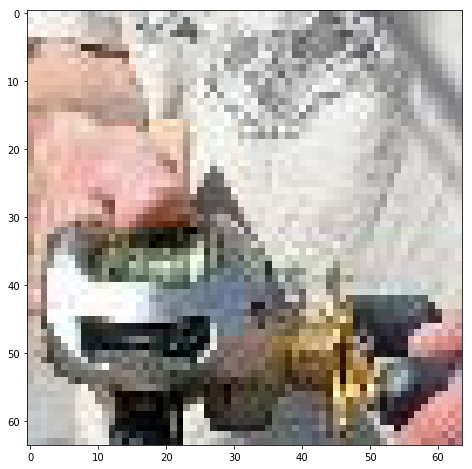

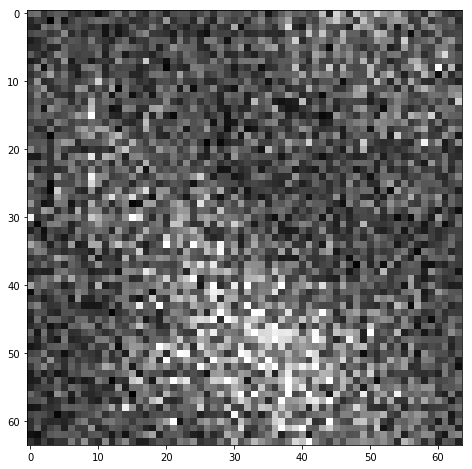

In [16]:
print("backprop")

special_idx = 360
with tf.Session(graph=tf.Graph()) as sess:
    saver = tf.train.import_meta_graph("model/checkpoint-59.meta")
    saver.restore(sess, "model/checkpoint-59")

    # Retrieve the Ops we 'remembered'.
    logits = tf.get_collection("logits")[0]
    images_placeholder = tf.get_collection("images")[0]
    labels_placeholder = tf.get_collection("labels")[0]
    keep_prob = tf.get_collection("prop")[0]
    
#     labels = tf.to_int64(labels_placeholder)
#     cross_entropy = tf.nn.sparse_softmax_cross_entropy_with_logits(
#         logits=logits, labels=labels, name='xentropy')
#     loss = tf.reduce_mean(cross_entropy, name='xentropy_mean')
    y = logits[0][labels_placeholder]
    gradX_op = tf.gradients(y, images_placeholder)[0]  

    # Run evaluation.
    images_feed = small_data['X_train'][special_idx]
    labels_feed = small_data['y_train'][special_idx]
    gradX = sess.run(gradX_op,
                          feed_dict={images_placeholder: images_feed,
                                     labels_placeholder: labels_feed,
                                     keep_prob: 1})
gradX = np.moveaxis(gradX, [0, 1, 2], [2, 0, 1])
print gradX.shape
image_2d = np.sum(np.abs(gradX), axis=2)
vmax = np.percentile(image_2d, 99)
vmin = np.min(image_2d)
dx = np.clip((image_2d - vmin) / (vmax - vmin), 0, 1)
print dx.shape

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

print small_data['class_names'][small_data['y_train'][special_idx]]
img = deprocess_image(small_data['X_train'][special_idx], small_data['mean_image'])
plt.imshow(img)
plt.show()
plt.imshow(dx)
plt.show()

In [18]:
from tensorflow.python.framework import ops
from tensorflow.python.ops import gen_nn_ops

@ops.RegisterGradient("GuidedRelu")
def _GuidedReluGrad(op, grad):
    return tf.where(0. < grad, gen_nn_ops._relu_grad(grad, op.outputs[0]), tf.zeros(grad.get_shape()))


In [22]:
def guidedBackprop(graph, session, y, x, feed_dict):
    with graph.as_default():
      saver = tf.train.Saver()
      saver.save(session, '/tmp/guided_backprop_ckpt')
        
    graph_def = graph.as_graph_def()

    guided_graph = tf.Graph()
    with guided_graph.as_default():
      guided_sess = tf.Session(graph = guided_graph)
#       with guided_graph.gradient_override_map({'Relu': 'GuidedRelu'}):
        # Import the graph def, and all the variables.
      tf.import_graph_def(graph_def, name='')
      saver.restore(guided_sess, '/tmp/guided_backprop_ckpt')
      imported_y = guided_graph.get_tensor_by_name(y.name)
      imported_x = guided_graph.get_tensor_by_name(x.name)
      guided_grads_node = tf.gradients(imported_y, imported_x)[0]
        
    with guided_graph.as_default():
      # Move all the feed dict tensor keys to refer to the same tensor on the
      # new graph.
      guided_feed_dict = {}
      for tensor in feed_dict:
        guided_feed_dict[tensor.name] = feed_dict[tensor]
    result = guided_sess.run(guided_grads_node, feed_dict = guided_feed_dict)[0]
    return result 

graph = tf.Graph()
with graph.as_default():
    sess = tf.Session(graph=graph)
    saver = tf.train.import_meta_graph("model/checkpoint-59.meta")
    saver.restore(sess, "model/checkpoint-59")   

    # Retrieve the Ops we 'remembered'.
    logits = tf.get_collection("logits")[0]
    images_placeholder = tf.get_collection("images")[0]
    labels_placeholder = tf.get_collection("labels")[0]
    keep_prob = tf.get_collection("prop")[0]
    
#     labels = tf.to_int64(labels_placeholder)
#     cross_entropy = tf.nn.sparse_softmax_cross_entropy_with_logits(
#         logits=logits, labels=labels, name='xentropy')
#     loss = tf.reduce_mean(cross_entropy, name='xentropy_mean')
    y = logits[0][labels_placeholder]
    gradX_op = tf.gradients(y, images_placeholder)[0]  

    
images_feed = small_data['X_train'][special_idx]
labels_feed = small_data['y_train'][special_idx]
gradX = guidedBackprop(graph, sess, gradX_op, images_placeholder, {images_placeholder: images_feed,
                                     labels_placeholder: labels_feed, keep_prob: 1})  


gradX = np.moveaxis(gradX, [0, 1, 2], [2, 0, 1])
print gradX.shape
image_2d = np.sum(np.abs(gradX), axis=2)
vmax = np.percentile(image_2d, 99)
vmin = np.min(image_2d)
dx = np.clip((image_2d - vmin) / (vmax - vmin), 0, 1)
print dx.shape

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'
plt.imshow(dx)
plt.show()

INFO:tensorflow:Restoring parameters from model/checkpoint-59
INFO:tensorflow:Restoring parameters from /tmp/guided_backprop_ckpt


LookupError: No gradient defined for operation 'gradients/conv1/norm1_grad/LRNGrad_1' (op type: LRNGrad)

In [9]:
print("guided backprop")
import saliency

graph = tf.Graph()
with graph.as_default():
    sess = tf.Session(graph=graph)
    saver = tf.train.import_meta_graph("model/checkpoint-199.meta")
    saver.restore(sess, "model/checkpoint-199")   

    # Retrieve the Ops we 'remembered'.
    logits = tf.get_collection("logits")[0]
    images_placeholder = tf.get_collection("images")[0]
    labels_placeholder = tf.get_collection("labels")[0]
    keep_prob = tf.get_collection("prop")[0]

    # Add an Op that chooses the top k predictions.
    eval_op = tf.nn.top_k(logits)
    eval_op = eval_op.indices[0][0]
    

images_feed, labels_feed = test_ds.next_batch(EVAL_BATCH_SIZE)
guided_backprop = saliency.GuidedBackprop(graph, sess, eval_op, images_placeholder)
# Compute the vanilla mask and the smoothed mask.
vanilla_guided_backprop_mask_3d = guided_backprop.GetMask(
  images_feed, feed_dict={labels_placeholder: labels_feed, keep_prob: 1})
smoothgrad_guided_backprop_mask_3d = guided_backprop.GetSmoothedMask(
  images_feed, feed_dict={labels_placeholder: labels_feed, keep_prob: 1})
print vanilla_guided_backprop_mask_3d
print vanilla_guided_backprop_mask_3d.shape


guided backprop
INFO:tensorflow:Restoring parameters from model/checkpoint-199


KeyError: "Registering two gradient with name 'GuidedRelu' !(Previous registration was in <module> /home/yangzhic/anaconda3/envs/tensorflow/lib/python2.7/site-packages/ipykernel_launcher.py:16)"